<a href="https://colab.research.google.com/github/johnnybalright/AlphApex_Floodway_Program_SRWMD/blob/main/plabz_samgeo_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q condacolab
import condacolab
condacolab.install()

!conda install -c conda-forge pdal python-pdal gdal
!conda install -c conda-forge scikit-image
%pip install segment-geospatial groundingdino-py leafmap localtileserver segment-anything-fast cloth-simulation-filter
%pip install segment-anything-fast
%pip install shapely
%pip install open3d
%pip install sklearn
%pip install laspy
%pip install rasterio
%pip install scipy
%pip install cloth-simulation-filter
%pip install alphashape

In [ ]:
import os
import geopandas as gpd
import pandas as pd
from shapely.affinity import scale
from shapely.ops import unary_union
from shapely.geometry import box, Polygon, LineString, Point
from shapely.strtree import STRtree
import pdal
import json
from sklearn.ensemble import IsolationForest
import numpy as np
import laspy
import colorsys
from samgeo import tms_to_geotiff
from samgeo.text_sam import LangSAM
from samgeo.hq_sam import show_image, download_file, overlay_images, tms_to_geotiff
from samgeo import tms_to_geotiff
import CSF
import open3d as o3d
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
from shapely.geometry import mapping


def segment_image(image_path, text_prompt, output_geojson_dir):
    sam = LangSAM()
    text_prompt = text_prompt
    sam.predict(image_path, text_prompt, box_threshold=0.18, text_threshold=0.24)
    os.makedirs(output_geojson_dir, exist_ok=True)
    sam.save_boxes(os.path.join(output_geojson_dir, "boxes.geojson"))


def union_intersecting_geometries(gdf, scale_factor=1):
    gdf['scaled_geometry'] = gdf['geometry'].apply(lambda geom: scale(geom, xfact=scale_factor, yfact=scale_factor, origin='center'))
    new_rows = []
    spatial_index = gdf.sindex
    processed_indices = set()
    for index, row in gdf.iterrows():
        if index in processed_indices:
            continue
        geom = row['scaled_geometry']
        possible_matches_index = list(spatial_index.intersection(geom.bounds))
        possible_matches = gdf.iloc[possible_matches_index]
        precise_matches = possible_matches[possible_matches['scaled_geometry'].intersects(geom)]
        if not precise_matches.empty:
            new_geom = unary_union(precise_matches['scaled_geometry'])
            row['geometry'] = new_geom
            new_rows.append(row)
            processed_indices.update(precise_matches.index)
    result_gdf = gpd.GeoDataFrame(new_rows, columns=gdf.columns).drop(columns=['scaled_geometry'])
    result_gdf.reset_index(drop=True, inplace=True)
    return result_gdf


def crop_las(input_las, output_dir, geojson_path):
    gdf = gpd.read_file(geojson_path)
    gdf = gdf.set_crs(epsg=4326)
    print(gdf.crs)
    gdf = gdf.to_crs(epsg=32617)
    print(gdf.crs)
    print(gdf)
    gdf['area'] = gdf['geometry'].area
    gdf = gdf.sort_values('area', ascending=False).iloc[1:].copy()
    gdf.drop('area', axis=1, inplace=True)
    updated_gdf = union_intersecting_geometries(gdf)
    bounding_box_df = updated_gdf.bounds
    bounding_box_gdf = gpd.GeoDataFrame(geometry=[box(minx, miny, maxx, maxy) for minx, miny, maxx, maxy in zip(bounding_box_df['minx'], bounding_box_df['miny'], bounding_box_df['maxx'], bounding_box_df['maxy'])], crs=updated_gdf.crs)
    print(bounding_box_gdf.crs)
    num_rows = len(bounding_box_gdf)
    print(f"Number of polygons: {num_rows}")
    i = 1
    for polygon in bounding_box_gdf['geometry']:
        output_path = os.path.join(output_dir, f"odm_struc_{i}.las")
        i = i + 1
        polygon_wkt = polygon.wkt
        print(f"wkt: {polygon_wkt}")

        pipeline_definition = {
        "pipeline": [
            {
            "type": "readers.las",
            "filename": input_las
            },
            {
            "type": "filters.crop",
            "polygon": polygon_wkt
            },
            {
            "type": "writers.las",
            "filename": output_path
            }
        ]
        }

        pipeline_str = json.dumps(pipeline_definition)
        pipeline = pdal.Pipeline(pipeline_str)
        pipeline.execute()

    return num_rows


def rgb_to_hsv(r, g, b):
    """Convert RGB to HSV color space. Assumes RGB values are in 16-bit (0-65535)."""
    r, g, b = r / 65535.0, g / 65535.0, b / 65535.0
    return colorsys.rgb_to_hsv(r, g, b)


def is_green(hsv, green_removal_ratio=1.0):
    """
    Determine if the color is a shade of green, adjusting based on green_removal_ratio.
    Expands or contracts the considered green hue range based on the ratio.
    """
    h, s, v = hsv
    base_start_hue, base_end_hue = 0.25, 0.4
    start_hue = base_start_hue - (0.05 * green_removal_ratio)
    end_hue = base_end_hue + (0.05 * green_removal_ratio)
    return start_hue <= h <= end_hue and s > 0.2


def filter_green(las_file):
    las = laspy.read(las_file)
    if all(hasattr(las, attr) for attr in ["red", "green", "blue"]):
        hsv_colors = np.array([rgb_to_hsv(r, g, b) for r, g, b in zip(las.red, las.green, las.blue)])
        green_removal_ratio = 3
        non_green_indices = [i for i, hsv in enumerate(hsv_colors) if not is_green(hsv, green_removal_ratio)]
        new_las = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
        new_las.points = las.points[non_green_indices]
        new_points = np.vstack((new_las.x, new_las.y, new_las.z)).transpose()
        new_rgb = np.vstack((new_las.red, new_las.green, new_las.blue)).transpose()
        return new_points, new_rgb


def minz_point_cloud(points, rgb):
    min_x, min_y, min_z = points.min(axis=0)
    max_x, min_y, max_z = points.max(axis=0)
    min_z_threshold = min_z + 3
    max_z_threshold = min_z + 5.5
    filter = (points[:, 2] > min_z_threshold) & (points[:, 2] < max_z_threshold)
    filtered_points = points[filter]
    filtered_rgb = rgb[filter]
    return filtered_points, filtered_rgb


def nonground_csf(xyz_array, smooth_param=True, resolution_param=0.4):
    if xyz_array is None:
        return None

    elif len(xyz_array) == 0:
        return None

    else:
        csf = CSF.CSF()
        csf.params.bSloopSmooth = smooth_param
        csf.params.cloth_resolution = resolution_param
        csf.setPointCloud(xyz_array)
        ground = CSF.VecInt()
        non_ground = CSF.VecInt()
        csf.do_filtering(ground, non_ground)
        nonground_arr = xyz_array[non_ground]
        return nonground_arr


def z_histogram(array, nth_dev=2):
    if array is None:
        return None

    elif len(array) == 0:
        return None

    else:
        means = np.mean(array, axis=0)
        std_devs = np.std(array, axis=0)
        lower_bounds = means - int(nth_dev) * std_devs
        upper_bounds = means + int(nth_dev) * std_devs
        mask = np.all((array > lower_bounds) & (array < upper_bounds), axis=1)
        filtered_array = array[mask]
        return filtered_array


def remove_outliers(array, nb_neighbors=3, std_ratio=0.25):
    """
    Remove outliers using Open3D's statistical outlier removal method and save the cleaned point cloud as a LAS file.

    :param pcd: Open3D point cloud from which to remove outliers.
    :param las: Original LAS data (needed for preserving header info).
    :param output_las_path: Path to save the cleaned LAS file.
    :param nb_neighbors: Number of neighbors to consider for each point.
    :param std_ratio: Standard deviation ratio threshold.
    """
    if array is None:
        return None

    elif len(array) == 0:
        return None

    else:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(array)
        cleaned_pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors,
                                                        std_ratio=std_ratio)
        return np.asarray(cleaned_pcd.points)


def random_sample(point_array, sample_size):
    """
    Randomly sample points from a 3D point cloud.

    Parameters:
    - point_cloud: A NumPy array of shape (N, 3), where N is the number of points in the point cloud.
    - sample_size: The number of points to sample from the point cloud. Must be less than or equal to N.

    Returns:
    - A NumPy array of the randomly sampled points, of shape (sample_size, 3).
    """
    if point_array is None:
        return None

    elif sample_size > len(point_array):
        return point_array

    else:
        indices = np.random.choice(len(point_array), size=sample_size, replace=False)
        sampled_points = point_array[indices]
        return sampled_points


def randtree(pcd_array):
    if pcd_array is None:
        return None

    elif len(pcd_array) == 0:
        return None

    else:
        clf = IsolationForest(random_state=42, contamination=0.03, max_samples=0.5)
        # clf = IsolationForest(random_state=42)
        clf.fit(pcd_array)
        is_inlier = clf.predict(pcd_array)
        filtered_points = pcd_array[is_inlier == 1]
        return filtered_points


def array_to_las(array, output_file_path):
    """
    Converts a NumPy array of point coordinates to a LAS file.

    Parameters:
        numpy_array (np.ndarray): NumPy array with shape (n, 3) containing XYZ coordinates.
        output_file_path (str): Path to the output LAS file.
    """
    if array is None:
        return None
    elif len(array) == 0:
        return None
    else:
        header = laspy.LasHeader(version="1.2", point_format=3)
        las = laspy.LasData(header)
        las.x = array[:, 0]
        las.y = array[:, 1]
        las.z = array[:, 2]
        las.write(output_file_path)


def bounding_box(points):
    """
    Calculate the axis-aligned bounding box of a point cloud.

    Parameters:
    - points: A numpy array of shape (N, 3), where N is the number of points.

    Returns:
    A tuple containing:
    - min_point: The minimum x, y, z coordinates of the bounding box.
    - max_point: The maximum x, y, z coordinates of the bounding box.
    """
    if points is None:
        return None, None

    elif len(points) == 0:
        return None, None

    else:
        min_point = np.min(points, axis=0)
        max_point = np.max(points, axis=0)
        return min_point, max_point



def create_bbox(points):
    """
    Calculate the 2D bounding box of a given array of 3D points and create a polygon.

    Args:
        points (numpy.ndarray): A numpy array of shape (n, 3), where n is the number of points.

    Returns:
        shapely.geometry.Polygon: A polygon representing the 2D bounding box of the provided points.
    """
    if points.ndim != 2 or points.shape[1] != 3:
        raise ValueError("Input points must be a 2D numpy array with three columns (x, y, z).")

    min_x, min_y = np.min(points[:, :2], axis=0)
    max_x, max_y = np.max(points[:, :2], axis=0)

    bottom_left = (min_x, min_y)
    bottom_right = (max_x, min_y)
    top_right = (max_x, max_y)
    top_left = (min_x, max_y)

    bbox_polygon = Polygon([bottom_left, bottom_right, top_right, top_left, bottom_left])

    return bbox_polygon


def detect_planes(points, distance_threshold=0.01, ransac_n=10, num_iterations=1000):
    """Use Open3D to detect multiple planes in the point cloud and save each plane to a separate LAS file."""
    pcd = o3d.geometry.PointCloud()
    if points is None:
        return None, None, None

    elif len(points) == 0:
        return None, None, None

    else:
        pcd.points = o3d.utility.Vector3dVector(points)
        cumulative_inliers_count = 0

        plane_models = []
        mbr_lst = []
        plane_count = 0

        nb_neighbors = 3
        std_ratio = 0.25
        voxel_size = 0.01
        downsampled_pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
        cleaned_pcd, ind = downsampled_pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors,
                                                        std_ratio=std_ratio)
        original_point_count = len(cleaned_pcd.points)
        while True:
            plane_model, inliers = cleaned_pcd.segment_plane(distance_threshold=distance_threshold,
                                                    ransac_n=ransac_n,
                                                    num_iterations=num_iterations)
            if len(inliers) < 100:
                break

            cumulative_inliers_count += len(inliers)
            inlier_pcd = cleaned_pcd.select_by_index(inliers)

            inlier_arr = np.asarray(inlier_pcd.points)
            mbr = minimum_bounding_rectangle(inlier_arr)
            mbr_lst.append(mbr)

            if cumulative_inliers_count >= 0.75 * original_point_count:
                break

            plane_models.append(plane_model)
            cleaned_pcd = cleaned_pcd.select_by_index(inliers, invert=True)
            plane_count += 1

        return plane_models, mbr_lst, cleaned_pcd


def filter_polygons(polygons):
    """
    Group polygons based on containment criteria.

    Parameters:
    polygons (list): List of polygons as Shapely Polygon objects.

    Returns:
    list: A list of lists, each containing polygons where the first polygon
          in each list is the reference polygon, and subsequent polygons are
          those that are either completely contained or at least 75% contained.
    """
    grouped_polygons = []
    while polygons:
        reference_polygon = polygons.pop(0)
        group = [reference_polygon]
        remove_indices = []
        for i, poly in enumerate(polygons):
            if reference_polygon.contains(poly) or (reference_polygon.intersection(poly).area / poly.area >= 0.75):
                group.append(poly)
                remove_indices.append(i)
        for index in sorted(remove_indices, reverse=True):
            polygons.pop(index)
        grouped_polygons.append(group)

    return grouped_polygons


def perform_union(bounding_boxes):
    """
    Perform a unary union on a list of Shapely Polygons (bounding boxes).

    Args:
        bounding_boxes (list of shapely.geometry.Polygon): A list of polygons representing bounding boxes.

    Returns:
        shapely.geometry.polygon.Polygon: A single Polygon representing the union of all provided bounding boxes.
    """
    if not bounding_boxes:
        return None

    for bbox in bounding_boxes:
        if not isinstance(bbox, Polygon):
            return None

    result_union = unary_union(bounding_boxes)
    return result_union


def minimum_bounding_rectangle(points):
    """
    Computes the minimum bounding rectangle of a set of points.

    Parameters:
    points (numpy.ndarray): Array of points where each row is a point and each column is a dimension.

    Returns:
    numpy.ndarray: Vertices of the minimum bounding rectangle if successful, otherwise None.
    """
    if points is None or len(points) < 3:
        print("Error: Need at least three points to form a convex hull.")
        return None

    points = np.array(points)
    if points.ndim != 2 or points.shape[1] < 2:
        print("Error: Input points array must be a 2D array with at least two dimensions.")
        return None

    try:
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        hull_points_2d = hull_points[:, :2]
        polygon = Polygon(hull_points_2d)
        min_rectangle = polygon.minimum_rotated_rectangle
        return min_rectangle

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None


def gdf_to_array(gdf):
    """
    Converts all geometries in a GeoDataFrame into a structured NumPy array,
    safely handling None geometries.

    Parameters:
    gdf (GeoDataFrame): A GeoDataFrame with a geometry column.

    Returns:
    numpy.ndarray: A structured NumPy array of coordinates or geometry type specifics.
    """
    geom_array = []
    for geom in gdf.geometry:
        if geom is not None:
            if geom.geom_type == 'Polygon':
                exterior_coords = np.array(geom.exterior.coords)
                geom_array.append(exterior_coords)
            elif geom.geom_type == 'Point':
                point_coords = np.array((geom.x, geom.y))
                geom_array.append(point_coords)
            elif geom.geom_type == 'LineString':
                line_coords = np.array(geom.coords)
                geom_array.append(line_coords)
        else:
            geom_array.append(None)

    geom_array = np.array(geom_array, dtype=object)

    return geom_array


def variance_test(points):
    variance = np.var(points[:, 2])
    variance_threshold = 1.0
    if variance < variance_threshold:
        print(f"variance below threshold--variance={variance}")
        return True
    else:
        print(f"variance exceeded threshold--variance={variance}")
        return False


def z_difference(points_array, threshold=1.829):
    """
    Computes the difference between the maximum and minimum z-values in a 3D point cloud.

    Parameters:
    point_cloud (numpy.ndarray): A NumPy array where each row represents a point in 3D space,
                                 and columns correspond to x, y, and z coordinates respectively.

    Returns:
    float: The difference between the maximum and minimum z-values in the point cloud.
    """
    if points_array.ndim != 2 or points_array.shape[1] < 3:
        return None

    z_values = points_array[:, 2]
    max_z = np.max(z_values)
    min_z = np.min(z_values)
    z_diff = max_z - min_z

    if z_diff <= threshold:
        return True
    else:
        return False


def align_point_cloud(points):
    centroid = np.mean(points, axis=0)
    translated_points = points - centroid
    pca = PCA(n_components=3)
    pca.fit(translated_points)
    aligned_points = pca.transform(translated_points)

    return aligned_points, pca.components_, centroid


def alpha_seg_struc(
        image_path,
        input_odm_las,
        output_geojson_dir,
        output_las_dir,
        output_shp_dir,
        sample_num,
        text_prompt
        ):
    image_path = image_path
    input_odm_las = input_odm_las
    output_geojson_dir = output_geojson_dir
    output_las_dir = output_las_dir
    output_shp_dir = output_shp_dir
    os.makedirs(output_las_dir, exist_ok=True)
    os.makedirs(output_shp_dir, exist_ok=True)
    geojson_path = os.path.join(output_geojson_dir, "boxes.geojson")

    sample_num = sample_num
    c = 1
    k = 1
    text_prompt = text_prompt
    segment_image(image_path, text_prompt, output_geojson_dir)
    num_row = crop_las(input_odm_las, output_las_dir, geojson_path)
    print(f"num_row: {num_row}")
    for i in range(num_row):
        input_las = os.path.join(output_las_dir, f"odm_struc_{k}.las")
        output_las = os.path.join(output_las_dir, f"odm_struc_{k}_2.las")
        output_path = os.path.join(output_shp_dir, f"odm_struc_{c}.shp")

        new_points, new_rgb = filter_green(input_las)

        z_diff = z_difference(new_points)
        if z_diff:
            dev = "2"
            zhist_arr = z_histogram(new_points, dev)
            smooth_param = False
            resolution_param = 2
            nonground_arr = nonground_csf(zhist_arr, smooth_param, resolution_param)
            planes, mbr, clean_pcd = detect_planes(nonground_arr)
            grouped_results = filter_polygons(mbr)
            mbrs = []
            for i in range(len(grouped_results)):
                mbrs.append(grouped_results[i-1][0])
            result_union = perform_union(mbrs)
            gdf_union = gpd.GeoDataFrame(geometry=[result_union], crs="EPSG:32617")
            gdf_arr = gdf_to_array(gdf_union)
            if gdf_arr is None:
                continue
            else:
                gdf_mbr = minimum_bounding_rectangle(gdf_arr[0])
                gdf_union_2 = gpd.GeoDataFrame(geometry=[gdf_mbr], crs="EPSG:32617")
                if clean_pcd is None:
                    clean_arr_2 = None
                else:
                    clean_arr_2 = np.asarray(clean_pcd.points)

                sample_size = sample_num
                sampled_arr = random_sample(clean_arr_2, sample_size)
                array_to_las(sampled_arr, output_las)

                if gdf_union_2 is None:
                    continue
                else:
                    gdf_union_2 = gdf_union_2.set_crs(epsg=32617)
                    gdf_union_2 = gdf_union_2.to_crs(epsg=6441)
                    gdf_union_2.to_file(output_path)

        else:
            nonground_arr = nonground_csf(new_points)
            dev = "2"
            zhist_arr = z_histogram(nonground_arr, dev)
            clean_arr = remove_outliers(zhist_arr)
            planes, mbr, clean_pcd = detect_planes(clean_arr)
            grouped_results = filter_polygons(mbr)
            mbrs = []
            for i in range(len(grouped_results)):
                mbrs.append(grouped_results[i-1][0])
            result_union = perform_union(mbrs)
            gdf_union = gpd.GeoDataFrame(geometry=[result_union], crs="EPSG:32617")
            gdf_arr = gdf_to_array(gdf_union)
            if gdf_arr is None:
                continue
            else:
                gdf_mbr = minimum_bounding_rectangle(gdf_arr[0])
                gdf_union_2 = gpd.GeoDataFrame(geometry=[gdf_mbr], crs="EPSG:32617")
                if clean_pcd is None:
                    clean_arr_2 = None
                else:
                    clean_arr_2 = np.asarray(clean_pcd.points)

                sample_size = sample_num
                sampled_arr = random_sample(clean_arr_2, sample_size)
                array_to_las(sampled_arr, output_las)

                if gdf_union_2 is None:
                    continue
                else:
                    gdf_union_2 = gdf_union_2.set_crs(epsg=32617)
                    gdf_union_2 = gdf_union_2.to_crs(epsg=6441)
                    gdf_union_2.to_file(output_path)

        c = c + 1
        k = k + 1


def combine_shapefiles(directory, output_shapefile):
    """
    Reads all shapefiles in the specified directory and combines their geometries into one shapefile.

    Parameters:
    - directory: The path to the directory containing the shapefiles.
    - output_shapefile: The path where the combined shapefile will be saved.
    """
    frames = []
    for filename in os.listdir(directory):
        if filename.endswith(".shp"):
            filepath = os.path.join(directory, filename)
            frames.append(gpd.read_file(filepath))
    combined_gdf = gpd.GeoDataFrame(pd.concat(frames, ignore_index=True))
    combined_gdf.to_file(output_shapefile)


def create_projection_lines(combined_shapefile_path, target_line_path, projected_lines_path, polygon_vertex_path):
    gdf_polygons = gpd.read_file(combined_shapefile_path)
    gdf_target_line = gpd.read_file(target_line_path)
    target_line = gdf_target_line.geometry.iloc[0]

    projected_lines_lst = []
    polygon_vertex_lst = []
    for index, row in gdf_polygons.iterrows():
        polygon= row.geometry
        projected_point_to_vertex = {}
        projected_points = []
        if polygon is not None:
            for vertex in polygon.exterior.coords:
                vertex_point = Point(vertex)
                projected_point = target_line.interpolate(target_line.project(vertex_point))
                projected_points.append(projected_point)
                projected_point_tuple = (projected_point.x, projected_point.y)
                projected_point_to_vertex[projected_point_tuple] = vertex

            distances = [target_line.project(Point(p)) for p in projected_points]
            sorted_points_with_distances = sorted(zip(projected_points, distances), key=lambda x: x[1])
            closest_points_on_line = [sorted_points_with_distances[0][0], sorted_points_with_distances[-1][0]]

            polygon_vertex_1 = Point(projected_point_to_vertex[(closest_points_on_line[0].x, closest_points_on_line[0].y)])
            polygon_vertex_2 = Point(projected_point_to_vertex[(closest_points_on_line[1].x, closest_points_on_line[1].y)])
            polygon_vertex_lst.append(polygon_vertex_1)
            polygon_vertex_lst.append(polygon_vertex_2)
            target_line_vertex_1 = closest_points_on_line[0]
            target_line_vertex_2 = closest_points_on_line[1]

            projected_line_1 = LineString([polygon_vertex_1, target_line_vertex_1])
            projected_line_2 = LineString([polygon_vertex_2, target_line_vertex_2])
            projected_lines_lst.append(projected_line_1)
            projected_lines_lst.append(projected_line_2)
        else:
            continue

    polygon_vertex_gs = gpd.GeoSeries(polygon_vertex_lst)
    polygon_vertex_gs = polygon_vertex_gs.set_crs(epsg=6441)
    polygon_vertex_gs.to_file(polygon_vertex_path)
    projected_lines_gs = gpd.GeoSeries(projected_lines_lst)
    projected_lines_gs = projected_lines_gs.set_crs(epsg=6441)
    projected_lines_gs.to_file(projected_lines_path)


In [ ]:
image_path = '/content/drive/MyDrive/plabz/ace_projects/23119/_drone/output/odm_orthophoto/odm_orthophoto_clipped.tif'
input_odm_las = "/content/drive/MyDrive/plabz/ace_projects/23119/_drone/output/odm_georeferencing/odm_georeferenced_model.las"
output_geojson_dir = '/content/drive/MyDrive/plabz/ace_projects/23119/test/geojson'
output_las_dir = "/content/drive/MyDrive/plabz/ace_projects/23119/test/las"
output_shp_dir = "/content/drive/MyDrive/plabz/ace_projects/23119/test/shp"
directory_path = "/content/drive/MyDrive/plabz/ace_projects/23119/test/shp"
combined_shapefile_path = "/content/drive/MyDrive/plabz/ace_projects/23119/test/shp/combined_shapefile.shp"
target_line_path = "/content/drive/MyDrive/plabz/ace_projects/23119/23119-hecras_line.shp"
projected_lines_path = "/content/drive/MyDrive/plabz/ace_projects/23119/test/shp/23119-proj_obs_lines.shp"
polygon_vertex_path = "/content/drive/MyDrive/plabz/ace_projects/23119/test/shp/struc_obs_points.shp"
sample_num = 10000
text_prompt = "building"

alpha_seg_struc(
        image_path,
        input_odm_las,
        output_geojson_dir,
        output_las_dir,
        output_shp_dir,
        sample_num,
        text_prompt
        )

combine_shapefiles(directory_path, combined_shapefile_path)
create_projection_lines(combined_shapefile_path, target_line_path, projected_lines_path, polygon_vertex_path)


final text_encoder_type: bert-base-uncased
EPSG:4326
EPSG:32617
                                             geometry
0   POLYGON ((283350.726 3347189.754, 283350.726 3...
1   POLYGON ((283349.143 3347207.137, 283349.143 3...
2   POLYGON ((283317.717 3347213.525, 283317.717 3...
3   POLYGON ((283254.811 3347197.819, 283254.811 3...
4   POLYGON ((283371.483 3347207.797, 283371.483 3...
5   POLYGON ((283319.957 3347199.226, 283319.957 3...
6   POLYGON ((283386.538 3347191.711, 283386.538 3...
7   POLYGON ((283364.798 3347199.513, 283364.798 3...
8   POLYGON ((283403.012 3347189.283, 283403.012 3...
9   POLYGON ((283330.134 3347214.759, 283330.134 3...
10  POLYGON ((283312.336 3347201.160, 283312.336 3...
11  POLYGON ((283314.809 3347197.205, 283314.809 3...
None
Number of polygons: 11
wkt: POLYGON ((283349.1425205786 3347207.1369488053, 283349.1425205786 3347219.079851409, 283331.6676963576 3347219.079851409, 283331.6676963576 3347207.1369488053, 283349.1425205786 3347207.1369488053))
wk

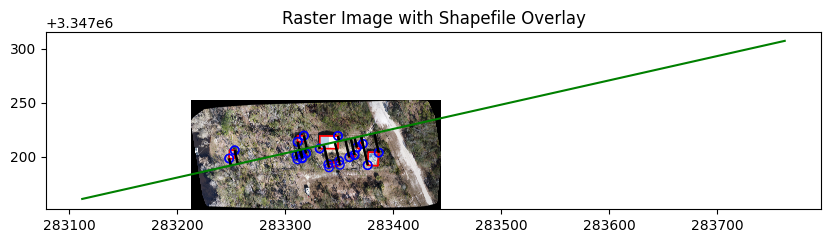

In [ ]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the raster file
raster_path = '/content/drive/MyDrive/plabz/ace_projects/23119/_drone/output/odm_orthophoto/odm_orthophoto.tif'
raster = rasterio.open(raster_path)

# Load the shapefile
shapefile_path_1 = '/content/drive/MyDrive/plabz/ace_projects/23119/test/shp/combined_shapefile.shp'
shapefile_1 = gpd.read_file(shapefile_path_1)
shapefile_1 = shapefile_1.set_crs(epsg=6441)
shapefile_1 = shapefile_1.to_crs(epsg=32617)

shapefile_path_2 = '/content/drive/MyDrive/plabz/ace_projects/23119/test/shp/struc_obs_points.shp'
shapefile_2 = gpd.read_file(shapefile_path_2)
shapefile_2 = shapefile_2.set_crs(epsg=6441)
shapefile_2 = shapefile_2.to_crs(epsg=32617)

shapefile_path_3 = '/content/drive/MyDrive/plabz/ace_projects/23119/test/shp/23119-proj_obs_lines.shp'
shapefile_3 = gpd.read_file(shapefile_path_3)
shapefile_3 = shapefile_3.set_crs(epsg=6441)
shapefile_3 = shapefile_3.to_crs(epsg=32617)

shapefile_path_4 = '/content/drive/MyDrive/plabz/ace_projects/23119/23119-hecras_line.shp'
shapefile_4 = gpd.read_file(shapefile_path_4)
shapefile_4 = shapefile_4.set_crs(epsg=6441)
shapefile_4 = shapefile_4.to_crs(epsg=32617)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot raster
show(raster, ax=ax)

# Overlay shapefile
shapefile_1.plot(ax=ax, facecolor='none', edgecolor='red')
shapefile_2.plot(ax=ax, facecolor='none', edgecolor='blue')
shapefile_3.plot(ax=ax, facecolor='none', edgecolor='black')
shapefile_4.plot(ax=ax, facecolor='none', edgecolor='green')
# Set title and show plot
ax.set_title('Raster Image with Shapefile Overlay')
plt.show()


In [ ]:
%pip install --upgrade google-api-python-client google-auth google-auth-httplib2 google-auth-oauthlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.27.0
    Uninstalling google-auth-2.27.0:
      Successfully uninstalled google-auth-2.27.0
  Attempting uninstall: google-auth-httplib2
    Found existing installation: google-auth-httplib2 0.1.1
    Uninstalling google-auth-httplib2-0.1.1:
      Successfully uninstalled google-auth-httplib2-0.1.1
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.84.0
    Uninstalling google-api-python-client-2.84.0:
      Successfully uninstalled google-api-python-client-2.84.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.27.0, bu

In [ ]:
Efrom google.oauth2.service_account import Credentials
from googleapiclient.discovery import build

# Path to your service account key file
SERVICE_ACCOUNT_FILE = '/content/drive/MyDrive/plabz/ace_projects/ace-api-396422-f3f2c7e42840.json'
SCOPES = ['https://www.googleapis.com/auth/drive']

credentials = Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE,
    scopes=SCOPES
)

drive_service = build('drive', 'v3', credentials=credentials)


In [ ]:
%pip install --upgrade google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client


In [ ]:
# !sudo -v ; curl https://rclone.org/install.sh | sudo bash
!rclone lsd gdrive: --config /content/drive/MyDrive/plabz/ace_projects/gdrive_config --drive-server-side-across-configs

In [ ]:
!rclone copy gdrive:"ACE Dropbox/templates/permit_table_template_2.xlsx" gdrive:"ACE Dropbox/PROJECTS/_aa_Most-Recent/" --drive-server-side-across-configs --config /content/drive/MyDrive/plabz/ace_projects/gdrive_config

In [ ]:
from ast import arg
import os
import subprocess


def find_binary(binary_name):
    potential_paths = ["/usr/bin", "/usr/local/bin", "/opt/bin"]
    for path in potential_paths:
        full_path = os.path.join(path, binary_name)
        if os.path.isfile(full_path):
            return full_path
    return None


def rclone_copy(full_path):
    rclone = full_path
    dir_1 = "gdrive:_aa_Most-Recent/templates/PermitTable.xlsx"
    dir_2 = "gdrive:_aa_Most-Recent/Rhodes-23119_g/Cadd"
    cmd = str(f"{rclone}")
    arg1 = str("copy")
    arg2 = str(dir_1)
    arg3 = str(dir_2)
    arg4 = str("--drive-server-side-across-configs")
    arg5 = str("--config")
    arg6 = str("/content/drive/MyDrive/plabz/ace_projects/gdrive_config")

    process_1 = subprocessPopen = subprocess.Popen(
        [cmd, arg1, arg2, arg3, arg4, arg5, arg6],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    stdout_1, stderr_1 = process_1.communicate()

    if process_1.returncode == 0:
        return stdout_1.decode()
    else:
        print("Rclone copy failed:", stderr_1.decode())


full_path = find_binary("rclone")
rclone_gsheet = rclone_copy_gsheet(full_path, project_number, lname)
print(rclone)


In [ ]:
!rclone copy gdrive:"ACE Dropbox/templates/PermitTable.xlsx" gdrive:"ACE Dropbox/PROJECTS/_aa_Most-Recent/Rhodes-23119_g/Cadd" --drive-server-side-across-configs --config /content/drive/MyDrive/plabz/ace_projects/gdrive_config

2024/04/22 04:04:49 Failed to create file system for "gdrive:ACE Dropbox/templates/PermitTable.xlsx": couldn't find root directory ID: Get "https://www.googleapis.com/drive/v3/files/root?alt=json&fields=id&prettyPrint=false&supportsAllDrives=true": couldn't fetch token - maybe it has expired? - refresh with "rclone config reconnect gdrive{Db_Y9}:": oauth2: cannot fetch token: 401 Unauthorized
Response: {
  "error": "unauthorized_client",
  "error_description": "Unauthorized"
}


In [ ]:

!rclone move gdrive:"ACE Dropbox/PROJECTS/_aa_Most-Recent/Rhodes-23119_g/Cadd/permit_table_template_2.xlsx" gdrive:"ACE Dropbox/PROJECTS/_aa_Most-Recent/Rhodes-23119_g/Cadd/PermitTable.xlsx" --drive-server-side-across-configs --config /content/drive/MyDrive/plabz/ace_projects/gdrive_config
